In [68]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
from PIL import Image

# img, mask 불러오기

In [69]:
# 플라스크 서버 연동할 때 경로랑 손가락 구분하는거 다시 생각해보기
def img_mask_read(hand_name, design_name):
    img = cv2.imread("./img/" + hand_name)
    mask = cv2.imread("./img/" + design_name)
    return img, mask

In [70]:
# 합성할 이미지
img = cv2.imread("./img/19.png") # 사용자 손 사진
mask = cv2.imread("./img/233.jpg") # 욜로 돌아간 뒤 잘라진 사진 

In [71]:
mask.shape

(150, 116, 3)

# img 영역 찾기

In [ ]:
def find_img_finger_1(img):
    dst = img[188:341, 257:364].copy()
    height, width, channel = dst.shape
    return dst, height, width

def find_img_finger_2(img):
    dst = img[236:391, 389:511].copy()
    height, width, channel = dst.shape
    return dst, height, width

def find_img_finger_3(img):
    dst = img[309:456, 537:664].copy()
    height, width, channel = dst.shape
    return dst, height, width

def find_img_finger_4(img):
    dst = img[390:507, 670:786].copy()
    height, width, channel = dst.shape
    return dst, height, width

In [72]:
# 1, 2, 3, 4 좌표 다 찾기 (ymin, ymax, xmin, xmax)
# 1번(검지) bndbox좌표(188, 341, 254, 372), 자를 좌표 : [188:341, 257:364]
# 2번(중지) bndbox좌표(235, 394, 388, 513), 자를 좌표 : [236:391, 389:511]
# 3번(약지) bndbox좌표(309, 458, 539, 664), 자를 좌표 : [309:456, 537:664]
# 4번(새끼) bndbox좌표(391, 512, 670, 786), 자를 좌표 : [390:507, 670:786]
# 사용자의 손톱 이미지를 자른다.
dst = img[188:341, 257:364].copy()

cv2.imshow('source', img)
cv2.imshow('cut image', dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [30]:
height, width, channel = dst.shape
print(height, width, channel)

153 107 3


# mask resize : 순서 뒤로 가야함

In [37]:
nail_resize = cv2.resize(nail,(107,153))

In [73]:
mask.shape

(150, 116, 3)

In [74]:
img.shape

(720, 960, 3)

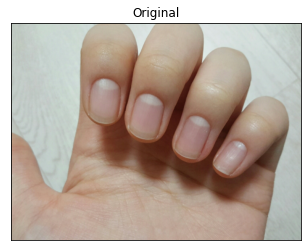

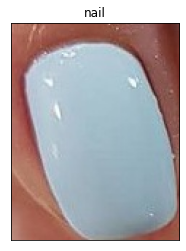

In [64]:
# mask 이미지를 붙일 위치의 배경 이미지 잘라내기(ROI)
rows, cols, channels = mask.shape
roi = img[188:188+153, 257:257+107]

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
mask = cv2.cvtColor(mask2, cv2.COLOR_RGB2BGR)

plt.title("Original")
plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

plt.title("nail")
plt.xticks([])
plt.yticks([])
plt.imshow(mask)
plt.show()

# mask 손톱만 이진화로 검출

In [73]:
def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()
        

        
def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation

def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [77]:
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)

In [78]:
# 손톱에서 피부 색만 제외한 부분 검은색으로 하기 
def find_design_nail(mask):
    nailBasic = imutils.resize(mask, width=250)
    # 손톱에서 피부색만 추출
    skin = extractSkin(nailBasic)
    dominantColors2 = extractDominantColor(skin, hasThresholding=True)
    prety_print_data(dominantColors2)
    # 추출해낸 피부색을 담고 있는 막대기
    colour_bar = plotColorBar(dominantColors2)
    return skin, mask

Color Information
{'cluster_index': 0,
 'color': [165.60986708178558, 96.28798946234156, 81.98215782541186],
 'color_percentage': 0.28417352128058976}

{'cluster_index': 4,
 'color': [139.67673201022689, 79.43151101911724, 70.24826494581907],
 'color_percentage': 0.2808286972251613}

{'cluster_index': 1,
 'color': [177.8697934896755, 122.73433671683736, 107.01680084004386],
 'color_percentage': 0.19475067408443975}

{'cluster_index': 3,
 'color': [143.8605633802815, 97.82840375586969, 93.07605633802962],
 'color_percentage': 0.14570463155739105}

{'cluster_index': 2,
 'color': [109.69503802969894, 52.74719304599793, 45.567910177471916],
 'color_percentage': 0.09454247585241816}

Color Bar


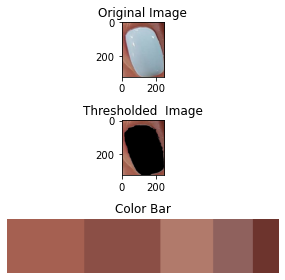

In [79]:
# nailBasic = cv2.imread("./img/233.jpg")
# nailBasicWeight, nailBasicHeight, channel = nailBasic.shape

nailBasic = imutils.resize(mask, width=250)

plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(nailBasic, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

skin2 = extractSkin(nailBasic)

plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin2, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")

dominantColors2 = extractDominantColor(skin2, hasThresholding=True)

print("Color Information")
prety_print_data(dominantColors2)

# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors2)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()

In [ ]:
# skin 색상을 제외한 손톱의 검은 영역을 흰색으로 반전시키기 
def black_2_white(skin):
    # skin색상 부분만 그레이로 바꾼뒤 검은색 손톱 부분 제외하고 흰색으로 처리하기
    nailGray2 = cv2.cvtColor(skin, cv2.COLOR_BGR2GRAY)
    th2, dst2 = cv2.threshold(nailGray2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # 흰색부분이 마스크가 되기 위해서 검은색 손톱 부분을 흰색으로 반전
    mask_b_inv = cv2.bitwise_not(dst2)

In [86]:
nailGray2 = cv2.cvtColor(skin2, cv2.COLOR_BGR2GRAY)
th2, dst2 = cv2.threshold(nailGray2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold:", th2)  # 131

cv2.imshow('src', nailGray2)
cv2.imshow('dst', dst2)
cv2.waitKey()
cv2.destroyAllWindows()

otsu's threshold: 54.0


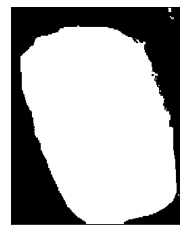

In [87]:
# 마스크 이미지 반전 - 흰색부분이 마스크가 되도록하기 위해서
mask_b_inv = cv2.bitwise_not(dst2)

plt.xticks([])
plt.yticks([])
plt.imshow(mask_b_inv, cmap="gray")
plt.show()

otsu's threshold: 54.0


In [75]:
roi.shape

(153, 107, 3)

In [99]:
dst2.shape

(323, 250)

In [101]:
mask2 = img_fg.copy()
height , weight = mask2.shape[:2]

In [102]:
nail20 = cv2.getRotationMatrix2D((weight//2 , height//2 ), -20, 1)
dst2 = cv2.warpAffine(mask2, nail20,(weight, height))
cv2.imshow('nail', dst2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [145]:
dst2 = cv2.resize(dst2,(107,153))

In [150]:
# ROI 이미지에서 마스크 부분만 추출하기
img_bg = cv2.bitwise_and(roi, roi, mask=mask_b_inv)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'


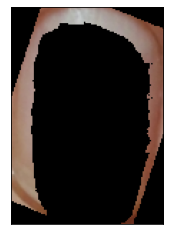

In [147]:
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_RGB2BGR)

plt.xticks([])
plt.yticks([])
plt.imshow(img_bg)
plt.show()

In [49]:
mask.shape

(150, 116, 3)

In [50]:
mask_b_inv.shape

(323, 250)

In [96]:
mask_b_inv = cv2.resize(mask_b_inv,(116,150))

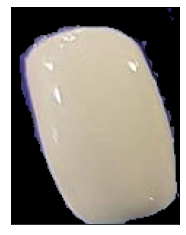

In [100]:
#마스크에 해당하는 이미지만 추출하기
img_fg = cv2.bitwise_and(mask, mask, mask=mask_b_inv)
# img_fg = cv2.cvtColor(img_fg, cv2.COLOR_RGB2BGR)

plt.xticks([])
plt.yticks([])
plt.imshow(img_fg)
plt.show()

In [106]:
# color_coverted = cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(img_fg)

In [107]:
import os, sys

# img = Image.open()
img = pil_image.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] < 10 and item[1] < 10 and item[2] < 10:
        newData.append((item[0], item[1], item[2], 0))
    else:
        newData.append(item)

img.putdata(newData)
# img.save("bg22.png")

In [108]:
# 여기는 플라스크 서버 연동하고 경로 변경해야함
pillow_img = Image.open("./img/19.png")
pillow_img.paste(pil_mask, (x, y), pil_mask)
pillow_img.show()

NameError: name 'pil_mask' is not defined

In [220]:
hand = Image.open("./img/19.png")
hand2 = hand.convert("RGBA")
hand2.save("./img/19-1.png")

In [188]:
cutting = cv2.imread("bg22.png", cv2.IMREAD_UNCHANGED)
# 결과를 출력한다.
cv2.imshow('source', cutting)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
pil_cut = Image.open("bg22.png")
pil_hand = Image.open("./img/19.png")

In [9]:
pil_cut = pil_cut.convert("RGBA")

In [10]:
pil_hand.paste(pil_cut, (257,188), pil_cut)
pil_hand.show()

In [105]:
pil_hand = Image.open("./img/19.png")
pil_hand.paste(img, (257,188), img)
pil_hand.show()

In [251]:
pil_hand.size

(960, 720)

In [252]:
new_image = Image.new("RGBA", (960, 270), (250,250,250,250))
new_image.paste(pil_hand, (0,0))
new_image.show()

In [253]:
new_image.paste(pil_cut,(257, 188))
new_image.save("merged_image.png","PNG")

In [169]:
numpy_image=np.array(cut) 
opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGBA2BGRA)

cv2.imshow('source', opencv_image)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [233]:
pil_cut.size

(116, 150)

In [ ]:
cut_resize = cut.resize(( )

In [181]:
opencv_image.shape

(150, 116, 3)

In [180]:
opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)

In [221]:
img = cv2.imread("./img/19-1.png", cv2.IMREAD_UNCHANGED)

In [222]:
img.shape

(720, 960, 4)

In [229]:
cut = cv2.imread('bg22.png', cv2.IMREAD_UNCHANGED)
cut_alpha = cut[:,:,3:]/255.0
backgroud_alpha = 1.0 - cut_alpha

cutting = cut_alpha * cut[:,:,3:] + backgroud_alpha * img[188:188+150, 257:257+116]
# 결과를 출력한다.
cv2.imshow('source', cutting)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [230]:
img[188:188+150, 257:257+116] = cutting

# 결과를 출력한다.
cv2.imshow('source', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [223]:
# 자른 이미지를 소스 이미지에 붙인다.
img[188:188+150, 257:257+116] = cutting

In [224]:
# 결과를 출력한다.
cv2.imshow('source', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [225]:
cv2.imwrite("bbbb.png", img)

True

In [216]:
cut = cv2.imread('bg22.png', cv2.IMREAD_UNCHANGED)

# 결과를 출력한다.
cv2.imshow('source', cut)

cv2.waitKey(0)
cv2.destroyAllWindows()
cut.shape

(150, 116, 4)

In [212]:
src = cv2.imread('bg22.png', cv2.IMREAD_UNCHANGED)

bgr = src[:,:,:3] # Channels 0..2
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# Some sort of processing...

bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
alpha = src[:,:,3] # Channel 3
result = np.dstack([bgr, alpha]) # Add the alpha channel

cv2.imshow('result',result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [213]:
result.shape

(150, 116, 4)